In [1]:
import sys
import pathlib
sys.path.append("..")

import shap
import matplotlib.pyplot as plt
import numpy as np
import torch
import plotly.express as px
import plotly.io as pio
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

from scripts.utils import load_datasets, get_config
from src.pretraining import PretrainedTimeDRL
from src.linear_models import LinearClassifier
from src.utils.visualization import plot_shap_values, plot_masking_result

In [2]:
DATASET_NAME = "HAR"
MODELS_DIR = pathlib.Path("../models")

config = get_config(DATASET_NAME, "pretraining")
train_ds, _, test_ds = load_datasets(DATASET_NAME, config)

if torch.cuda.is_available(): 
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = PretrainedTimeDRL.load_from_checkpoint(
    MODELS_DIR / f"{DATASET_NAME}_pretrained.ckpt", device, strict=False
)
print(f"Using device: {model.device}")

Using device: mps:0


/opt/homebrew/anaconda3/envs/timeseries/lib/python3.9/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/opt/homebrew/anaconda3/envs/timeseries/lib/python3.9/site-packages/lightning/pytorch/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['cls_reconstructor.1.weight', 'cls_reconstructor.1.bias']


In [3]:
train_cls, train_timesteps, train_labels = model.get_representations_from_dataloader(
    DataLoader(train_ds, batch_size=10, shuffle=False)
)

test_cls, test_timesteps, test_labels = model.get_representations_from_dataloader(
    DataLoader(test_ds, batch_size=10, shuffle=False)
)

Extracting representations from dataloader: 100%|██████████| 295/295 [00:13<00:00, 21.82batch/s]


Training LinearClassifier: 100%|██████████| 30/30 [00:16<00:00,  1.87epoch/s]


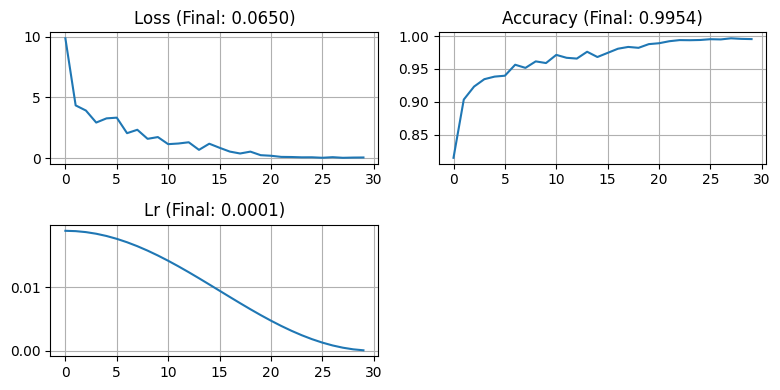

In [4]:
def plot_history(history):
    fig = plt.figure(figsize=(8, 4))
    for i, (name, data) in enumerate(history.items()):
        ax = fig.add_subplot(len(history) // 2 + 1, 2, i + 1)
        ax.plot(data)
        ax.set_title(f"{name.title().replace('_', ' ')} (Final: {data[-1]:.4f})")
        ax.grid(True)
    fig.tight_layout()
    return fig

classifier = LinearClassifier(
    dropout_rate=0.2,
    learning_rate=config["finetuning"]["learning_rate"],
    weight_decay=config["finetuning"]["weight_decay"],
    epochs=30,
    device=device,
    random_state=849213,
)
classifier.fit(train_timesteps, train_labels)

fig = plot_history(classifier.history_)

In [5]:
test_preds = classifier.predict(test_timesteps)

{
    "accuracy": accuracy_score(test_labels, test_preds),
    "macro_f1": f1_score(test_labels, test_preds, average="macro"),
    "kappa": cohen_kappa_score(test_labels, test_preds)
}

{'accuracy': 0.8754665761791652,
 'macro_f1': 0.8802437742590802,
 'kappa': np.float64(0.8504200564961985)}

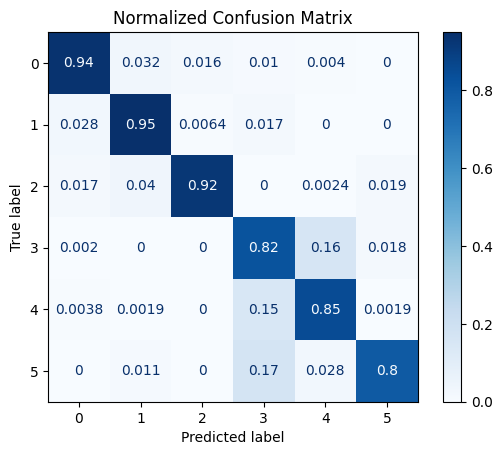

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create confusion matrix plot
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(
    test_labels, test_preds, ax=ax,
    display_labels=classifier.classes_,
    cmap='Blues', normalize='true',
)
ax.set_title('Normalized Confusion Matrix')
plt.show()

In [7]:
N, T, D = train_timesteps.shape
sequences = np.concatenate((train_timesteps, np.zeros((1, T, D))))
sample_ixs = np.column_stack([np.arange(N)] * T)

eval_count = 0

def f(sample_ix: np.ndarray):
    global eval_count
    if eval_count == 0:
        print(f"Shape of batches: {sample_ix.shape}")
    eval_count += 1
    input = sequences[sample_ix, np.arange(T)[np.newaxis, :]]
    probs = classifier.predict_proba(input, return_logits=False)
    return probs

def masker(mask: np.ndarray, sample_ix: np.ndarray):
    masked = sample_ix.copy()
    masked[~mask] = -1
    return masked[np.newaxis, :]

explainer = shap.Explainer(f, masker)
shap_values = explainer(sample_ixs, batch_size=100)
print(f"Called classifier.predict_proba {eval_count} times")

Shape of batches: (65, 32)


PermutationExplainer explainer: 5882it [04:02, 23.23it/s]                          


Called classifier.predict_proba 47047 times


In [8]:
importance = np.mean(shap_values.abs.values, axis=0).T

importance_norm = (
    importance - importance.mean(axis=-1, keepdims=True)
) / importance.std(axis=-1, keepdims=True)
fig = px.imshow(
    importance_norm,
    color_continuous_scale="Viridis",
    aspect="auto",
)
fig.update_xaxes(title_text="Timestep Index")
fig.update_yaxes(
    title_text="Class Index", tickmode="array",
    tickvals=np.arange(importance_norm.shape[0]),
    ticktext=[str(i) for i in range(importance_norm.shape[0])]
)
fig.show()

In [9]:
# from scipy.stats import norm

# time = np.linspace(0, 4 * np.pi, 500)
# interference_times = torch.load(
    # "../datasets/classification/Synthetic/train.pt", weights_only=False
# )["interference_times"]
# interference = np.array([
    # np.array([norm.pdf(time, loc=t) for t in channel_]).max(axis=0)
    # for channel_ in interference_times
# ])

# px.imshow(
    # interference, aspect="auto",
    # labels={"x": "Timestep Index", "y": "Class Index", "color": "Interference"},
    # y=np.arange(interference.shape[0]),
    # x=np.arange(interference.shape[1]) / (interference.shape[1] / T)
# )

In [10]:
importance_order = np.argsort(importance, axis=-1)
importance_order

array([[11,  8, 17, 10, 13, 24,  2, 16, 20, 29, 15, 14, 28, 23, 25, 30,
        22, 18, 12,  9, 26, 27, 31,  1,  3,  7, 21,  6,  4,  5, 19,  0],
       [ 7, 17,  4, 29, 27,  9, 12, 11,  2,  3, 23, 19, 31, 15, 16, 26,
        30, 28, 22,  6,  5, 18,  0, 21,  8, 13,  1, 25, 10, 14, 24, 20],
       [ 4, 25,  3, 12, 21, 20, 30,  5, 16, 22, 11,  6,  8, 10, 18, 24,
        13, 19, 17, 31, 29,  0, 14, 23, 26,  1, 15,  9, 28,  2, 27,  7],
       [ 6, 22, 17, 18, 21, 28,  9,  1, 12,  2, 19, 20, 15,  3, 10, 24,
        25,  5, 16,  7, 13, 11,  8, 23, 27,  0,  4, 26, 30, 31, 29, 14],
       [ 6, 19,  2, 24, 13, 28, 20,  4, 10,  3, 25,  9, 12, 22, 15,  7,
        31,  0,  1, 14, 23, 29, 26, 16, 21, 30, 18, 11, 27, 17,  8,  5],
       [27, 31, 14, 26,  0, 13, 12, 30, 29, 19, 28,  1,  8, 23, 21, 20,
         5, 11, 16, 15, 17, 10,  9, 18, 22,  3,  7,  4,  6, 25, 24,  2]])

In [21]:
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc
from src.masking import mask_timesteps

from plotly.subplots import make_subplots
from plotly.colors import qualitative

masking_percentages = np.array([0.25, 0.5, 0.7, 0.9])

color_map = qualitative.Plotly
fig = make_subplots(
    rows=1, cols=len(masking_percentages),
    subplot_titles=[" "] * len(masking_percentages),
    shared_yaxes=True, horizontal_spacing=0.02,
)

for i, percentage in enumerate(masking_percentages):
    masked_count = int(T * percentage)

    auc_mean = 0
    for label in classifier.classes_:
        masks = np.stack([
            np.random.choice(T, size=masked_count, replace=False)
            for _ in range(test_timesteps.shape[0])
        ])
        # masks = np.random.choice(T, size=masked_count, replace=False)
        # masks = importance_order[test_labels, :masked_count]
        masked = mask_timesteps(test_timesteps, masks)
        probs = classifier.predict_proba(masked)
        fpr, tpr, thresholds = roc_curve(test_labels, probs[:, label], pos_label=label)
        auc_mean += auc(fpr, tpr)

        fig.add_scatter(
            x=fpr, y=tpr, name=f"Class {label} vs Rest", mode="lines",
            line=dict(color=color_map[label]),
            showlegend=(i == 0), row=1, col=i+1
        )

    auc_mean = auc_mean / classifier.n_classes_

    fig.layout.annotations[i].update(
        text=f"Masked {int(percentage*100)}%<br>Mean AUC: {auc_mean:.2f}"
    )

    fig.add_scatter(
        x=[0, 1], y=[0, 1], showlegend=False,
        line=dict(color="gray", dash="dash"),
        row=1, col=i+1, name=""
    )

fig.update_yaxes(title_text="True Positive Rate", row=1, col=1)
fig.update_yaxes(showgrid=True, gridcolor="lightgray", griddash="dash")
fig.update_xaxes(
    title_text="False Positive Rate", showgrid=True,
    gridcolor="lightgray", griddash="dash", tickmode="array",
    tickvals=np.linspace(0, 1, 5)
)
fig.update_layout(
    template="simple_white",
    margin=dict(l=20, r=20, t=50, b=0), height=350,
    legend=dict(orientation="h", yanchor="bottom", y=-0.4, xanchor="center", x=0.5)
)
fig.show(config={"toImageButtonOptions": {"scale": 6}})

In [12]:
from src.masking import masking_impact

masking_percentages = np.linspace(0, 0.9, 10)

masking_result = np.array([
    masking_impact(
        classifier,
        test_timesteps,
        test_labels,
        importance_order[label],
        masking_percentages,
        metric="accuracy",
    )
    for label in classifier.classes_
])

random = np.array([
    masking_impact(
        classifier, test_timesteps, test_labels,
        "random", masking_percentages,
        metric="accuracy",
    ) for _ in range(15)
])

fig = plot_masking_result(
    masking_percentages,
    ("Random Masking", random),
    *[
        (f"Masking by Importance Order of Class {label}", result)
        for label, result in zip(classifier.classes_, masking_result)
    ],
)
fig.data[0].update(line={"width": 4, "dash": "dashdot"})
fig.data[1].update(fillcolor=str(fig.data[1].fillcolor).replace("0.15", "0.3"))
fig.update_yaxes(title_text="Accuracy")
fig.update_layout(
    legend=dict(
        orientation="v", yanchor="bottom",
        xanchor="left", y=0.03, x=0.01,
        bordercolor="lightgray", borderwidth=1,
    ), margin=dict(t=40)
)

fig1 = plot_masking_result(
    masking_percentages,
    *[
        (f"{label}", masking_impact(
            classifier,
            test_timesteps[test_labels != label],
            test_labels[test_labels != label],
            importance_order[label],
        ))
        for label in classifier.classes_
    ],
)
fig1.update_yaxes(title_text="Accuracy on<br>All Other Classes", range=[0.6, 1])
fig1.update_xaxes(title_text=None)
fig1.update_layout(showlegend=False, height=200, margin=dict(t=40))

fig2 = plot_masking_result(
    masking_percentages,
    *[
        (f"{label}", masking_impact(
            classifier,
            test_timesteps[test_labels != label],
            test_labels[test_labels != label],
            "random",
        ))
        for label in classifier.classes_
    ],
)
for i in range(len(fig2.data)):
    fig2.data[i].update(line={"dash": "dash"})
fig2.update_yaxes(title_text="Accuracy on<br>All Other Classes", range=[0.6, 1])
fig2.update_layout(showlegend=False, height=240, margin=dict(t=40))

import plotly.graph_objects as go
import ipywidgets as widgets

widgets.HBox([
    go.FigureWidget(fig),
    widgets.VBox([go.FigureWidget(fig1), go.FigureWidget(fig2)])
])

    'data': [{'hovertemplate': '%{y:.4f}',
              'legendgroup': 'Random …

In [13]:
fig = plot_masking_result(
    masking_percentages,
    *[
        (f"Class {label}", masking_impact(
            classifier,
            test_timesteps[test_labels == label],
            test_labels[test_labels == label],
            importance_order[label],
        ))
        for label in classifier.classes_
    ],
)
fig.update_yaxes(title_text="True Positive Rate")
fig.show(config={"toImageButtonOptions": {"scale": 6}})

In [14]:
from src.masking import masking_impact

masked_percentages = np.linspace(0, 0.9, 10)  # 10 steps from 0 to 0.9

accuracy_shap = masking_impact(
    classifier, test_timesteps, test_labels,
    importance_order[test_labels],
    masked_percentages,metric="accuracy",
)
accuracy_random = []
for _ in range(15):
    accuracy_random.append(
        masking_impact(
            classifier, test_timesteps, test_labels,
            order="random", metric="accuracy",
            masked_percentages=masked_percentages,
        )
    )
accuracy_random = np.array(accuracy_random)

In [15]:
from src.utils.visualization import plot_masking_result

plot_masking_result(
    masked_percentages,
    ("SHAP", accuracy_shap),
    ("Random", accuracy_random)
)